In [1]:
import os
import sys
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt

Here I just define the directories that point to the sspmodel directory and the directory of the LEGA-C spectra.

In [2]:
sspmodel_dir = '/Users/aprado/Desktop/sspmodel_py/' #'/home/gmosby/sspmodel_py_clean/sspmodel_py/'
legac_dir =  '/Users/aprado/Desktop/astropy/spectraDR/' #'/home/gmosby/LEGAC/spectraDR/'

We want to take a look at how the spectra need to be formatted for SSPMPDEL first, so we look at one of the example spectra FITS files.

In [3]:
#Find input spectrum
specfiles = glob.glob(sspmodel_dir+'example/*_off_axis.fits')
print("Found %d FITS files"%(len(specfiles)))
print(specfiles)

Found 4 FITS files
['/Users/aprado/Desktop/sspmodel_py/example/legac_M13_230105_v2.0_off_axis.fits', '/Users/aprado/Desktop/sspmodel_py/example/tau_2gyr_newdfk_sn_005_ps_000_r000_off_axis.fits', '/Users/aprado/Desktop/sspmodel_py/example/tau_10gyr_14Jun02_per_000_sn_005_ps_000_r000_off_axis.fits', '/Users/aprado/Desktop/sspmodel_py/example/tau_2gyr_newdfk_sn_020_ps_000_r000_off_axis.fits']


We take a look at the HDU, grab its header and see what we need to have in a FITS file for SSPMODEL.

In [4]:
spechdu = fits.open(specfiles[0])

In [5]:
print(spechdu.info())

Filename: /Users/aprado/Desktop/sspmodel_py/example/legac_M13_230105_v2.0_off_axis.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (4123, 1)   float32   
None


In [6]:
spechdr = spechdu[0].header

In [7]:
spechdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4123                                                  
NAXIS2  =                    1                                                  
EXTEND  =                    T                                                  
CDELT1  =                  0.6                                                  
CRVAL1  =               6541.3                                                  

The key parts are that the FITS file has NAXIS = 2, we can do this by just making sure the data we save has 2 dimensions, and that we have CRVAL1 and CDELT1 keywords. These keywords allow the code to reconstruct the wavelengh for each flux point without having to carry around the wavelength array values. The keywords in this file are in meters, but SSPMODEL can handle these values in Angstroms as well. In the example conversion below. I use Angstroms.

## Converting LEGA-C spectra

Here I grab the LEGA-C spectra FITS Binary Tables and take a look inside the header. We have the data we need to form some of the keywords we need.

In [8]:
legafiles = glob.glob(legac_dir+'*.fits')
print("Found %d files"%(len(legafiles)))

Found 1992 files


In [9]:
legaspechdu = fits.open(legafiles[0])
fav = '/Users/aprado/Desktop/astropy/spectraDR/legac_M13_230105_v2.0.fits'
fav = fits.open(fav)

In [10]:
legaspechdu.info()

Filename: /Users/aprado/Desktop/astropy/spectraDR/legac_M2_210716_v2.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  PHASE3SPECTRA    1 BinTableHDU     46   1R x 4C   [6166E, 6166E, 6166E, 6166I]   


In [11]:
fav.info()

Filename: /Users/aprado/Desktop/astropy/spectraDR/legac_M13_230105_v2.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     200   ()      
  1  PHASE3SPECTRA    1 BinTableHDU     46   1R x 4C   [6166E, 6166E, 6166E, 6166I]   


In [12]:
legaspechdr = fav[0].header#legaspechdu[0].header

In [13]:
favhdr = fav[0].header

In [14]:
legaspechdr

SIMPLE  =                    T /Written by IDL:  Wed Jun 13 14:45:05 2018       
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T /File contains extensions                        
DATE    = '2018-06-13'         /                                                
ORIGIN  = 'ESO     '           /European Southern Observatory                   
TELESCOP= 'ESO-VLT-U3'         /ESO <TEL>                                       
INSTRUME= 'VIMOS   '           /Instrument used                                 
DISPELEM= 'HR_red  '           /                                                
SPECSYS = 'TOPOCENT'           /                                                
OBJECT  = 'M13_230105'         /                                                
EXT_OBJ =                    T /                                                
RA      =           149.9190

In [15]:
favhdr

SIMPLE  =                    T /Written by IDL:  Wed Jun 13 14:45:05 2018       
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T /File contains extensions                        
DATE    = '2018-06-13'         /                                                
ORIGIN  = 'ESO     '           /European Southern Observatory                   
TELESCOP= 'ESO-VLT-U3'         /ESO <TEL>                                       
INSTRUME= 'VIMOS   '           /Instrument used                                 
DISPELEM= 'HR_red  '           /                                                
SPECSYS = 'TOPOCENT'           /                                                
OBJECT  = 'M13_230105'         /                                                
EXT_OBJ =                    T /                                                
RA      =           149.9190

If you scroll through the LEGAC header we have WAVELMIN that we can use as CRVAL1--we just have to convert from nanometers to Angstroms. And we have SPEC_BIN which we can use as the CDELT1, but we must also convert it to Angstroms. There's also another important thing to check and that's whether using those two values we get the right wavelength array.

In [16]:
nwave = (legaspechdr['WAVELMAX'] - legaspechdr['WAVELMIN'])/legaspechdr['SPEC_BIN'] + 1

#Using header values to get wavelengths
waves_nm = legaspechdr['WAVELMIN'] + legaspechdr['SPEC_BIN']*np.arange(nwave)
waves_ang = waves_nm*10

#Setting header values to SSPMODEL expected header variable names
cdelt = legaspechdr['SPEC_BIN']*10
crval1 = legaspechdr['WAVELMIN']*10

To check that the WAVELMIN and SPEC_BIN values work as we expect, we compare what we have in waves_ang to what is in the binary FITS Table included in the LEGAC spectrum column WAVE

In [17]:
legaspectab = legaspechdu[1].data
legaspectab.columns


ColDefs(
    name = 'WAVE'; format = '6166E'; unit = 'angstrom'
    name = 'FLUX'; format = '6166E'; unit = '10**(-19) erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'ERR'; format = '6166E'; unit = '10**(-19) erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'QUAL'; format = '6166I'
)

In [18]:
#Grab Binary FITS Table Columns for spectrum's wavelength and flux
flux_tab = legaspectab['FLUX']
wave_tab = legaspectab['WAVE']

In [19]:
print(waves_ang) # This is for the legac original header
print(wave_tab) # THis is for the fits file we are makinG?
print(flux_tab)

[6541.3 6541.9 6542.5 ... 9013.9 9014.5 9015.1]
[[5800.3 5800.9 5801.5 ... 9498.1 9498.7 9499.3]]
[[0. 0. 0. ... 0. 0. 0.]]


There seems to be a mismatch. It turns out the keywords in the LEGAC header point to the region of the spectrum where there are nonzero valid flux parameters. So, we'll want to make sure we only grab those nonzero flux points. When we compare the wavelengths we get from using the keywords to the wavelengths for the valid flux parameters, they match.

In [20]:
wave_good = wave_tab[flux_tab != 0]
flux_good = flux_tab[flux_tab != 0]*1e-19
nwave_good = len(wave_good)
print(wave_good)
print(waves_ang)

[6787.3 6787.9 6788.5 ... 9270.7 9271.3 9271.9]
[6541.3 6541.9 6542.5 ... 9013.9 9014.5 9015.1]


Now, we can go about writing the spectrum to a 1D spectrum FITS file for SSPMODEL. As we saw above the SSPMODEL style spectrum is saved to a single PrimaryHDU. We then set the CRVAL1 and CDELT1 keywords. To make sure we have a properly formatted NAXIS keywords, we use None in the first index as we set the data of the PrimaryHDU. We then check that the header looks valid. And finally write the fits file.

In [21]:
#Save spectrum's flux to PrimaryHDU
phdu = fits.PrimaryHDU(data=flux_good[None,:])
#Set wavelength keywords
phdu.header['CRVAL1'] = crval1
phdu.header['CDELT1'] = cdelt

In [22]:
#Check header looks correct
phdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4142                                                  
NAXIS2  =                    1                                                  
EXTEND  =                    T                                                  
CRVAL1  =               6541.3                                                  
CDELT1  =                  0.6                                                  

In [23]:
#Write the FITS file (in this case I write it to the same same directory as the original since I
#use the split technique here to form the filename)
phdu.writeto(legac_dir+'legac_M12_92014_v2.0.fits'+'_off_axis.fits', overwrite=True)#legafiles[0].split('.fits')[0]+'_off_axis.fits', overwrite=True)

In [24]:
obj0 = fav
obj0.info()

Filename: /Users/aprado/Desktop/astropy/spectraDR/legac_M13_230105_v2.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     200   ()      
  1  PHASE3SPECTRA    1 BinTableHDU     46   1R x 4C   [6166E, 6166E, 6166E, 6166I]   


[8100.7    8102.5    8103.0996 8103.7    8104.3    8104.9    8105.5
 8106.0996 8106.7    8107.3    8107.9    8109.0996 8109.7    8766.7
 8835.1    8884.3    8914.3    8914.9    8915.5    8916.1    8916.7
 8917.3    8917.9    8918.5   ]


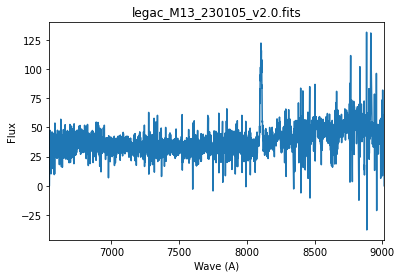

In [25]:
# data0 = obj0[1].data
# # SPECTRA
wave = obj0[1].data['WAVE']
flux = obj0[1].data['FLUX']
#Masking to plot only nonzero values of flux (to just look at the interesting parts of the spectra)
flux_cutoff = np.where(flux != 0)
flux = flux[flux_cutoff]
#Plot wave only where flux != 0
wave = wave[flux_cutoff]

fig, ax = plt.subplots()
ax.plot(wave, flux,'-')
ax.set_xlim(wave[0], wave[-2])
ax.set_xlabel('Wave (A)')
ax.set_ylabel('Flux')
#LEGA-c spectra used for symposium PPT presentation:
ax.set_title('legac_M13_230105_v2.0.fits')  #'legac_M12_92014_v2.0.fits')

#ROUGH Estimate of wavelength ranges where emission lines occur:
emission_lines = np.where(flux > 100)
print(wave[emission_lines])

In [27]:
# 'legac_M13_230105_v2.0.fits'


# emission lines ~ 8100 Å, 8700~ishÅ